## Moody's cluster

In this notebook, I use Harvard Atlas ECI to cluster Emerging Markets Economies (EME)


In [ ]:
#%pip install altair   # Some packages need to be installed to the virtual machine before we can import them into our notebook. We can do this with '!pip install'


In [1]:
#pip install xlrd

  Using cached wbgapi-1.0.12-py3-none-any.whl.metadata (13 kB)
  Using cached tabulate-0.9.0-py3-none-any.whl.metadata (34 kB)
Using cached wbgapi-1.0.12-py3-none-any.whl (36 kB)
Using cached tabulate-0.9.0-py3-none-any.whl (35 kB)
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
#!pip install --upgrade nbformat

In [34]:
import pandas as pd
import numpy as np
import altair as alt
import requests
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from json import loads, dumps

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotnine import *


## 1) Interactive map of complexity rankings

### Importing data

In [2]:
######################
# Harvard Atlas of EC
# 1) Economic Complexity Index https://atlas.hks.harvard.edu/data-downloads
eci = pd.read_csv('../data/growth_proj_eci_rankings.csv') 

# 2) Country codes
continent_labels = pd.read_csv('../data/location_group_member.csv') 

#######################
# World bank indicators 
# 3) Manufacturing, value added (% of GDP) https://data.worldbank.org/indicator/NV.IND.MANF.ZS
manufacturing = pd.read_csv('../data/API_NV.IND.MANF.ZS_DS2_en_csv_v2_130159.csv', skiprows=4)

# 4) Medium and high-tech manufacturing value added: https://data.worldbank.org/indicator/NV.MNF.TECH.ZS.UN
high_tech = pd.read_csv('../data/API_NV.MNF.TECH.ZS.UN_DS2_en_csv_v2_6516.csv', skiprows=4)

# 5) Industry (including construction), value added (% of GDP)
industry = pd.read_csv('../data/API_NV.IND.TOTL.ZS_DS2_en_csv_v2_6498.csv', skiprows=4)

# 6) Agriculture, forestry, and fishing, value added (% of GDP) https://data.worldbank.org/indicator/NV.AGR.TOTL.ZS
agriculture = pd.read_csv('../data/API_NV.AGR.TOTL.ZS_DS2_en_csv_v2_128624.csv', skiprows=4)

# 7) Services, value added (% of GDP) https://data.worldbank.org/indicator/NV.SRV.TOTL.ZS 
services = pd.read_csv('../data/API_NV.SRV.TOTL.ZS_DS2_en_csv_v2_129290.csv', skiprows=4)

# 8)Total natural resources rents (% of GDP) https://data.worldbank.org/indicator/NY.GDP.TOTL.RT.ZS
natural_resources = pd.read_csv('../data/API_NY.GDP.TOTL.RT.ZS_DS2_en_csv_v2_129611.csv', skiprows=4)


### Cleaning 

In [3]:
# 1) ECI
eci_clean = eci[['country_id', 'country_iso3_code', 'year', 'eci_hs92', 'eci_rank_hs92']]

eci_clean = eci_clean[(eci_clean['year']>=2015) & (eci_clean['year']<=2024)]
eci_clean = eci_clean.rename(columns={'country_iso3_code': 'country_code',
                                      'eci_hs92':'eci'}).drop(columns={'eci_rank_hs92'})

# 2) Continent labels
continent_labels_clean = eci_clean.merge(continent_labels, on= 'country_id', how='left')

continent_labels_clean = continent_labels_clean[(continent_labels_clean['group_type'] == 'continent')]
continent_labels_clean = continent_labels_clean[['group_name', 'country_code']]
continent_labels_clean = continent_labels_clean.rename(columns={'group_name':'continent'})
continent_labels_clean = continent_labels_clean.drop_duplicates(subset='country_code', keep='first')

# 2) World Bank indicators
wb = pd.concat([manufacturing, high_tech, industry, agriculture, services, natural_resources], ignore_index=True)

wb = wb.drop(columns=['Indicator Code'])
wb = wb.rename(columns={'Country Name': 'country_name',
                        'Country Code': 'country_code',
                        'Indicator Name': 'variable_name'})

# Years to 1 variable
wb_long = pd.melt(
    wb,
    id_vars= ['country_name', 'country_code','variable_name'],  # columns to keep fixed
    value_vars=[str(year) for year in range(1960, 2025)],  # columns to melt
    var_name='year',                       # name of the new column for years
    value_name='value'       # name of the new column for values
)

wb_long['year'] = wb_long['year'].astype(int)
wb_long_clean = wb_long[(wb_long['year'] >= 2015) & (wb_long['year'] <= 2024)]

# Split Variable name into vars
wb_wide = wb_long_clean.pivot(
    index=['country_name', 'country_code','year'],      # column to make new rows (unique identifiers)
    columns='variable_name',   # column whose unique values become new columns
    values='value'             # column with values to fill the new cells
).reset_index()

wb_wide = wb_wide.rename(columns={'Agriculture, forestry, and fishing, value added (% of GDP)': 'agriculture',
                                 'Industry (including construction), value added (% of GDP)': 'industry',
                                'Manufacturing, value added (% of GDP)': 'manufacturing',
                                'Medium and high-tech manufacturing value added (% manufacturing value added)': 
                                'tech', 
                                'Services, value added (% of GDP)': 'services',
                                 'Total natural resources rents (% of GDP)': 'natural_resources'})

# 3) List of high natural resources countries
nat_res_list = wb_long[
    (wb_long['year'].between(1990, 2000)) &
    (wb_long['variable_name'] == 'Total natural resources rents (% of GDP)')
]

nat_res_list = nat_res_list.groupby(['country_name', 'country_code'], as_index=False)[
        ['value']
    ].mean()


In [4]:
nat_res_list

,country_name,country_code,value
0,Afghanistan,AFG,NaN
1,Africa Eastern and Southern,AFE,6.653759
2,Africa Western and Central,AFW,16.081789
3,Albania,ALB,3.755188
4,Algeria,DZA,18.506758
...,...,...,...
261,West Bank and Gaza,PSE,0.000000
262,World,WLD,1.649423
263,"Yemen, Rep.",YEM,28.818333
264,Zambia,ZMB,7.755428


### Append datasets

In [5]:
wb_wide

variable_name,country_name,country_code,year,agriculture,industry,manufacturing,tech,services,natural_resources
0,Afghanistan,AFG,2015,20.634323,22.124042,11.420006,9.507434,53.235293,0.469917
1,Afghanistan,AFG,2016,25.740314,10.466808,4.114197,8.464749,59.023216,0.617410
2,Afghanistan,AFG,2017,26.420199,10.051874,3.530422,6.901329,58.329050,0.702982
3,Afghanistan,AFG,2018,22.042897,13.387247,6.160177,6.412409,59.477423,0.855264
4,Afghanistan,AFG,2019,25.773971,14.058112,7.043181,8.464966,55.472807,0.682288
...,...,...,...,...,...,...,...,...,...
2655,Zimbabwe,ZWE,2020,8.772859,32.767518,15.696567,9.586613,52.892576,4.746668
2656,Zimbabwe,ZWE,2021,8.849899,28.805586,12.442934,9.586613,56.639869,6.398452
2657,Zimbabwe,ZWE,2022,7.170550,39.691641,20.533465,9.586613,41.547127,NaN
2658,Zimbabwe,ZWE,2023,4.108254,26.301060,16.429474,NaN,62.410733,NaN


In [6]:
# ECI with wb
df =  eci_clean.merge(wb_wide,on=['country_code', 'year'], how='left')

#### Collapsed dataset: Average values from 2015 to 2024

In [7]:
df_collapsed = (
    df.groupby(['country_name', 'country_code'], as_index=False)[
        ['eci', 'agriculture', 'industry', 'manufacturing', 'services', 'tech', 'natural_resources']
    ].mean()
)

df_collapsed.to_csv('../data/df_collapsed.csv', index=False)
df_collapsed.head()

,country_name,country_code,eci,agriculture,industry,manufacturing,services,tech,natural_resources
0,Afghanistan,AFG,-1.257889,28.069954,14.090503,7.335604,52.966067,8.143223,0.580338
1,Albania,ALB,-0.503222,17.986197,23.329693,6.793486,45.096745,5.097777,1.386207
2,Algeria,DZA,-1.064444,11.458396,34.945123,7.645180,49.480644,2.693262,16.997479
3,Angola,AGO,-1.157000,10.613892,45.339530,6.695511,43.778591,3.344511,24.471356
4,Argentina,ARG,-0.232000,5.858420,23.204334,14.541561,55.049764,26.446247,1.621936


In [8]:
#df_clean = nat_res_list.merge(df_collapsed, on=['country_code', 'country_name'], how='left').drop('natural_resources').rename(columns={'value': 'natural_resources'})

df_clean = df_collapsed[df_collapsed['natural_resources']>df_collapsed['natural_resources'].median()] # Median is 2.3%?


df_clean.head()

,country_name,country_code,eci,agriculture,industry,manufacturing,services,tech,natural_resources
2,Algeria,DZA,-1.064444,11.458396,34.945123,7.645180,49.480644,2.693262,16.997479
3,Angola,AGO,-1.157000,10.613892,45.339530,6.695511,43.778591,3.344511,24.471356
6,Australia,AUS,-0.377111,2.402959,24.979089,5.708141,65.953625,27.116398,6.116301
8,Azerbaijan,AZE,-0.927889,5.653957,48.443012,5.242427,38.027065,12.344045,20.414431
9,Bahrain,BHR,0.504111,0.278689,41.391728,18.561283,56.082299,23.493400,12.700419


#### Checking NAs

In [9]:
print("Missing values per variable:\n")

for col in df_clean.columns:
    missing_share = df_clean[col].isna().mean()  # fraction of missing values
    print(f"{col}: {missing_share:.2%}")

Missing values per variable:

country_name: 0.00%
country_code: 0.00%
eci: 0.00%
agriculture: 0.00%
industry: 0.00%
manufacturing: 7.04%
services: 0.00%
tech: 16.90%
natural_resources: 0.00%


## Cluster

In [10]:
df_clean

,country_name,country_code,eci,agriculture,industry,manufacturing,services,tech,natural_resources
2,Algeria,DZA,-1.064444,11.458396,34.945123,7.645180,49.480644,2.693262,16.997479
3,Angola,AGO,-1.157000,10.613892,45.339530,6.695511,43.778591,3.344511,24.471356
6,Australia,AUS,-0.377111,2.402959,24.979089,5.708141,65.953625,27.116398,6.116301
8,Azerbaijan,AZE,-0.927889,5.653957,48.443012,5.242427,38.027065,12.344045,20.414431
9,Bahrain,BHR,0.504111,0.278689,41.391728,18.561283,56.082299,23.493400,12.700419
...,...,...,...,...,...,...,...,...,...
138,Uzbekistan,UZB,-0.501111,23.949517,28.637439,16.800107,39.778077,18.757348,12.151255
140,Viet Nam,VNM,-0.018556,12.701614,36.368541,23.288097,42.087371,38.426239,2.771299
141,"Yemen, Rep.",YEM,-1.298667,25.250764,27.783867,NaN,42.965369,2.064957,2.427893
142,Zambia,ZMB,-0.620111,3.637019,36.409666,7.760425,54.257673,9.770166,15.316242


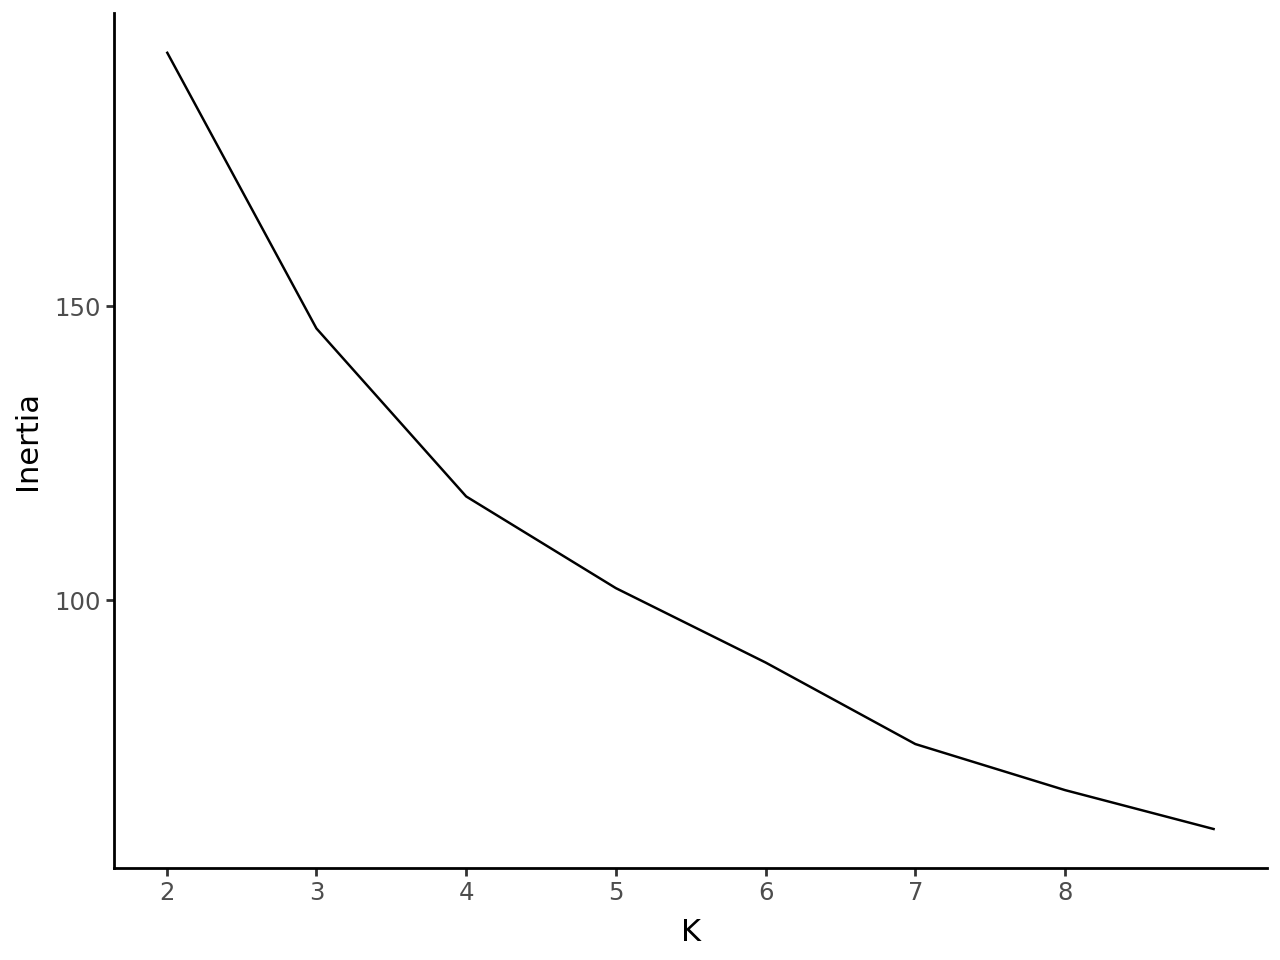

In [35]:
df_clean_nona = df_clean.dropna()

# Standardize variables
cols_cluster = ['eci','agriculture' ,'industry','manufacturing', 'services']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clean_nona[cols_cluster])

# Run KMeans with k=4


k = range(2,10)
inertia = []

for i in k:
    kmeans = KMeans(n_clusters=i, n_init=20, random_state=421)
    kmeans.fit(X_scaled)

    inertia.append(kmeans.inertia_)

d_plot = pd.DataFrame({'inertia':inertia},
             index=k
             ).reset_index()
(
    ggplot(d_plot) +
    geom_line(aes(x='index', y='inertia')) +
    theme_classic() +
    labs(x='K', y='Inertia') +
    scale_x_continuous(breaks=d_plot.index+1)
    )

In [36]:
# Drop rows with missing values (optional)
df_clean_nona = df_clean.dropna()

# Standardize variables
cols_cluster = ['eci','agriculture' ,'industry','manufacturing', 'services']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clean_nona[cols_cluster])

# Run KMeans with k=4
kmeans = KMeans(n_clusters=4, random_state=42)
df_clean_nona['cluster'] = kmeans.fit_predict(X_scaled)

# Continent labels 
df_wide_nona= df_clean_nona.merge(continent_labels_clean, on='country_code', how = 'left')

# View result
df_wide_nona.head()


C:\Users\iorueta\AppData\Local\Temp\ipykernel_36152\3207459554.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,country_name,country_code,eci,agriculture,industry,manufacturing,services,tech,natural_resources,cluster,continent
0,Algeria,DZA,-1.064444,11.458396,34.945123,7.645180,49.480644,2.693262,16.997479,2,Africa
1,Angola,AGO,-1.157000,10.613892,45.339530,6.695511,43.778591,3.344511,24.471356,2,Africa
2,Australia,AUS,-0.377111,2.402959,24.979089,5.708141,65.953625,27.116398,6.116301,0,Oceania
3,Azerbaijan,AZE,-0.927889,5.653957,48.443012,5.242427,38.027065,12.344045,20.414431,2,Asia
4,Bahrain,BHR,0.504111,0.278689,41.391728,18.561283,56.082299,23.493400,12.700419,0,Asia


### Plotting

#### 1) Scatter plot

In [37]:
# Scatter 3D
fig = px.scatter_3d(
    df_wide_nona,
    x='eci',
    y='industry',
    z='manufacturing',
    color='cluster',
    symbol='continent',
    hover_name='country_code',  # only show country_code as main hover label
    hover_data={'cluster': True, 'continent': False, 
                'eci': False, 'agriculture': False, 
                'industry': False, 'manufacturing': False, 'tech': False}
)

# Layout adjustments
fig.update_layout(
    title='K-Means Clusters of Countries (k=3)',
    width=800,
    height=600,
    legend=dict(
        orientation="h",
        y=-0.2,
        x=0.5,
        xanchor='center',
        yanchor='top'
    )
)

fig.show(renderer="browser")


#### 2) Map with natural resources rent (% of gdp)

In [38]:
# Load the geojson data
geojson_url = "https://raw.githubusercontent.com/EconomicsObservatory/courses/main/datasets/advanced/map_world.geojson"
geojson = alt.Data(url=geojson_url, format=alt.DataFormat(property='features', type='json'))

# Define the year slider
year_slider = alt.binding_range(min=1995, max=2022, step=1, name='Select year:')
year_select = alt.selection_point(
    name="yearSelector",
    fields=['year'],
    bind=year_slider,
    value={'year': 2022}
)

# Define selections
country_selection = alt.selection_point(on='mouseover', fields=['country_name'])

# Compute rank by ECI (for coloring)
#df_collapsed['eci_rank'] = df_clean.groupby('year')['eci'].rank(ascending=False)

# Create the chart
map_chart = (
    alt.Chart(df_collapsed)
    .mark_geoshape(stroke='white', strokeWidth=0.3)
    .encode(
        color=alt.condition(
            "isValid(datum.natural_resources)",
            alt.Color(
                'natural_resources:Q',
                legend=alt.Legend(
                    title='',
                    format='d',
                    direction='vertical',
                    orient='left',
                    titleFontSize=16,
                    labelFontSize=11,
                    gradientLength=300,
                    values=[0, 20],
#                    labelExpr="datum.value == 1 ? '1st' : datum.value == 2 ? '2nd' : datum.value == 3 ? '3rd' : datum.value + 'th'"
                ),
                scale=alt.Scale(domain=[0, 20], scheme='viridis')
            ),
            alt.value('lightgrey')
        ),
        tooltip=[
            alt.Tooltip('country_name:N', title='Country Name'),
            alt.Tooltip('natural_resources:Q', title='Natural resources (% of GDP)', format='.2f'),
#            alt.Tooltip('eci:Q', title='ECI', format='.2f'),
#            alt.Tooltip('agriculture:Q', title='Agriculture', format='.2f'),
#            alt.Tooltip('industry:Q', title='Industry', format='.2f'),
#            alt.Tooltip('manufacturing:Q', title='Manufacturing', format='.2f')
        ]
    )
    .transform_lookup(
        lookup='country_code',
        from_=alt.LookupData(geojson, 'properties.ISO3', ['type', 'geometry', 'properties'])
    )
    .project(
        type='naturalEarth1',
        scale=125,
        translate=[285, 180]
    )
    .properties(
        width=700,
        height=400,
        title={
            "text": "Total natural resources rents (% of GDP)",
            "subtitle": "Average 2015-2024 (%)",
            "fontSize": 16,
            "subtitleFontSize": 12,
            "subtitleFontWeight": "lighter",
            "anchor": "middle"
        }
    )
)

map_chart.show()

alt.Chart(...)

#### 3) Map with clusters

In [41]:
# Load the geojson data
geojson_url = "https://raw.githubusercontent.com/EconomicsObservatory/courses/main/datasets/advanced/map_world.geojson"
geojson = alt.Data(url=geojson_url, format=alt.DataFormat(property='features', type='json'))

# Define the year slider
year_slider = alt.binding_range(min=1995, max=2022, step=1, name='Select year:')
year_select = alt.selection_point(
    name="yearSelector",
    fields=['year'],
    bind=year_slider,
    value={'year': 2022}
)

# Define selections
country_selection = alt.selection_point(on='mouseover', fields=['country_name'])

# Compute rank by ECI (for coloring)
#df_wide_nona['eci_rank'] = df_clean.groupby('year')['eci'].rank(ascending=False)

# Create the chart
df_wide_nona['cluster'] = df_wide_nona['cluster'].astype(str)

map_chart = (
    alt.Chart(df_wide_nona)
    .mark_geoshape(stroke='white', strokeWidth=0.3)
    .encode(
        color=alt.condition(
            "isValid(datum.cluster)",
            alt.Color(
                'cluster:N',
                legend=alt.Legend(
                    title='Clusters',
                    format='d',
                    direction='vertical',
                   columns=3,
                    orient='bottom',
                    titleFontSize=25,
                    labelFontSize=20,
                    gradientLength=300,
                    values=['0', '1', '2', '3'],
#                    labelExpr="datum.value == 1 ? '1st' : datum.value == 2 ? '2nd' : datum.value == 3 ? '3rd' : datum.value + 'th'"
                ),
                scale=alt.Scale(
                    domain=['0', '1', '2', '3'],
                    range=['#4C72B0', '#55A868', '#C44E52', '#F0E442']  # blue, green, red, yellow
            ) 
            ),
            alt.value('lightgrey')
        ),
        tooltip=[
            alt.Tooltip('country_name:N', title='Country Name'),
            alt.Tooltip('cluster:N', title='Cluster',),
            alt.Tooltip('eci:Q', title='ECI', format='.2f'),
            alt.Tooltip('agriculture:Q', title='Agriculture', format='.2f'),
            alt.Tooltip('industry:Q', title='Industry', format='.2f'),
            alt.Tooltip('manufacturing:Q', title='Manufacturing', format='.2f'),
            alt.Tooltip('services:Q', title='Services', format='.2f')
        ]
    )
    .transform_lookup(
        lookup='country_code',
        from_=alt.LookupData(geojson, 'properties.ISO3', ['type', 'geometry', 'properties'])
    )
    .project(
        type='naturalEarth1',
        scale=125,
        translate=[285, 180]
    )
    .properties(
        width=700,
        height=400,
        title={
            "text": "Clusters for EME with a prevalence of natural resources",
            "subtitle": [
                f"Selected vars: {cols_cluster}."
            ],
            "fontSize": 16,
            "subtitleFontSize": 12,
            "subtitleFontWeight": "lighter",
            "anchor": "middle"
        }
    )
)

map_chart.show()


alt.Chart(...)

#### Variables heatmap

In [16]:
df_wide_nona

,country_name,country_code,eci,agriculture,industry,manufacturing,services,tech,natural_resources,cluster,continent
0,Algeria,DZA,-1.064444,11.458396,34.945123,7.645180,49.480644,2.693262,16.997479,2,Africa
1,Angola,AGO,-1.157000,10.613892,45.339530,6.695511,43.778591,3.344511,24.471356,2,Africa
2,Australia,AUS,-0.377111,2.402959,24.979089,5.708141,65.953625,27.116398,6.116301,0,Oceania
3,Azerbaijan,AZE,-0.927889,5.653957,48.443012,5.242427,38.027065,12.344045,20.414431,2,Asia
4,Bahrain,BHR,0.504111,0.278689,41.391728,18.561283,56.082299,23.493400,12.700419,0,Asia
5,Bolivia,BOL,-1.057556,12.173677,25.404416,10.517458,49.819063,11.939234,4.822919,1,South America
6,Brazil,BRA,0.059444,5.166366,20.000023,11.312710,61.133270,33.125325,3.646853,0,South America
7,Cameroon,CMR,-1.171778,16.965920,24.693261,13.527178,50.461696,7.611958,5.516432,1,Africa
8,Chile,CHL,-0.441222,3.820101,28.616336,9.360842,57.422908,17.811437,6.192927,0,South America
9,Colombia,COL,0.080222,7.170306,26.088053,11.347789,57.386154,23.588552,3.950476,0,South America


Variables found in dataset: ['agriculture', 'industry', 'services', 'manufacturing', 'eci']


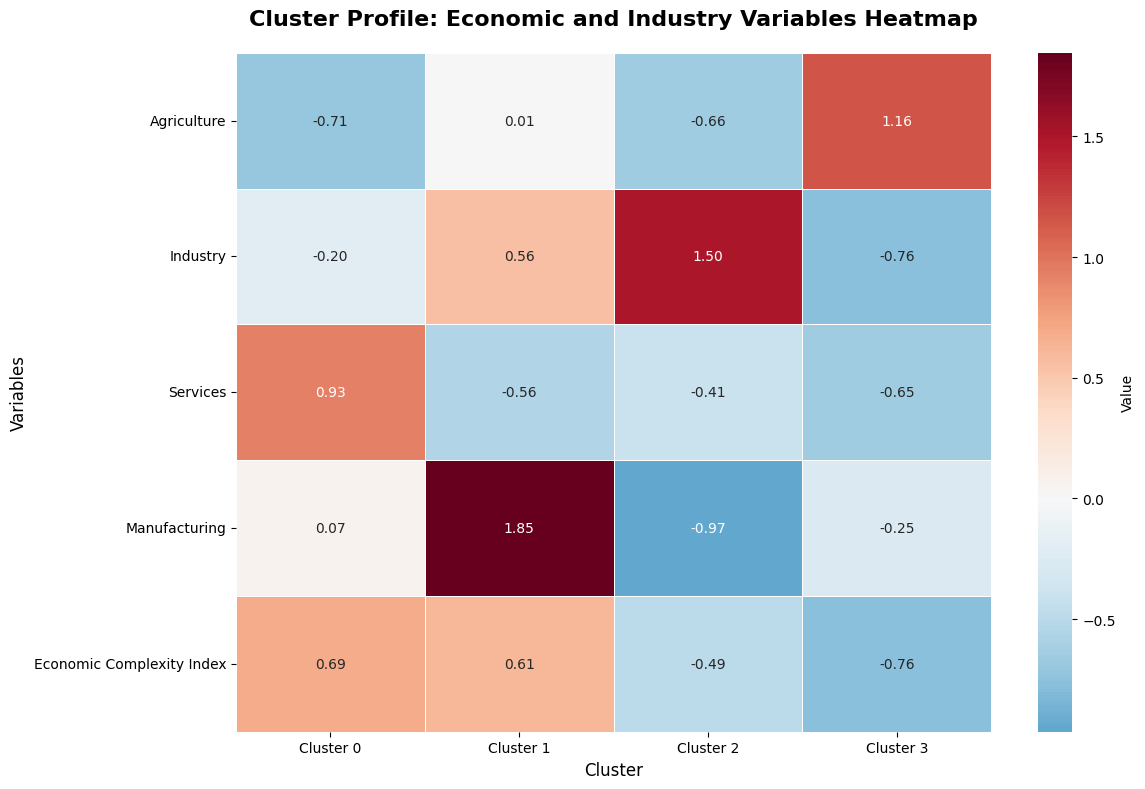

In [42]:
# Select only the variables of interest
variables_of_interest = ['agriculture', 'industry', 'services', 'manufacturing', 'eci']
cluster_col = 'cluster'

# Check if all variables exist in the dataframe
existing_vars = [var for var in variables_of_interest if var in df_wide_nona.columns]
print(f"Variables found in dataset: {existing_vars}")

# Calculate cluster means for the selected variables
df_standardized = df_wide_nona.copy()
df_standardized[existing_vars] = scaler.fit_transform(df_wide_nona[existing_vars])

# Calculate cluster means on standardized data
cluster_means_std = df_standardized.groupby(cluster_col)[existing_vars].mean()

# ============================================
# COMPREHENSIVE OVERVIEW HEATMAP
# ============================================
plt.figure(figsize=(12, 8))

# Create labels for the variables (more descriptive names)
variable_labels = {
    'agriculture': 'Agriculture',
    'industry': 'Industry',
    'manufacturing': 'Manufacturing',
    'services': 'Services', 
    'eci': 'Economic Complexity Index'
}

# Get the labels in the correct order
labels_ordered = [variable_labels.get(var, var) for var in existing_vars]

# Identify cluster labels based on unique clusters
unique_clusters = sorted(df_standardized[cluster_col].unique())
cluster_labels = [f'Cluster {i}' for i in unique_clusters]

# Create the heatmap data (transpose for better visualization)
heatmap_data = cluster_means_std[existing_vars].T

# Create the heatmap
sns.heatmap(heatmap_data, 
            annot=True, 
            fmt='.2f', 
            cmap='RdBu_r', 
            center=0,
            cbar_kws={'label': 'Value'},
            xticklabels=cluster_labels,
            yticklabels=labels_ordered,
            linewidths=0.5,
            annot_kws={'size': 10})

plt.title('Cluster Profile: Economic and Industry Variables Heatmap', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Variables', fontsize=12)
plt.tight_layout()
plt.show()


# To do:
- Include services (% of GDP) READY
- Elbow test
- Check missing countries
- Use natural resources from 1990 to 2000
- Play with the five variables.
- Interpretation of clusters
- Do PCA

#### Casey
- Filtering on t on natural resources and clustering on t+1
- Variable selection (how many, which ones)
- Missing values
Ayaan inputed values with kmeans.
Ignacio took averages from the last 10 years. 
- Client stuff (what to show to them and when)
